# Transfer Learning in NLP


In this notebook, we will go through basics of Transfer Learning in NLP using  BERT and also compare the results of custom embeddings on LSTM, BiLSTM, GRU with BERT on [Twitter US Airline Sentiment dataset](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

### Dataset

Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").  It contains whether the sentiment of the tweets in this set was positive, neutral, or negative for six US airlines


Here we will use [PyTorch](https://pytorch.org/tutorials/  "PyTorch Tutorial").


Everything is explained in-detail in [blog post](https://dudeperf3ct.github.io/nlp/transfer/learning/2019/02/22/Power-of-Transfer-Learning-in-NLP/). This is notebook which replicates the result of blog and runs in colab. Enjoy!


#### Run in Colab

You can run this notebook in google colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dudeperf3ct/DL_notebooks/blob/master/tl_nlp/tl_nlp_pytorch.ipynb)


### Results

|  Approach | Epoch  | Time (sec)  | Train Accuracy(%)  | Dev Accuracy (%)  |
|---|---|---|---|---|
| LSTM  |  10  | 25  |  98 |  78.8 |
| BiLSTM |  10 |  35 |  98 | 79.1  |
| GRU  |  10 |  27 |  92 | 79.3  |
| BERT  |  3 | 600  |  - | 85.03  |


## Download pytorch pretrained

In [1]:
!pip install spacy ftfy==4.4.3
!python -m spacy download en

    100% |████████████████████████████████| 51kB 2.4MB/s 
    100% |████████████████████████████████| 17.3MB 2.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/37/54/00/d320239bfc8aad1455314f302dd82a75253fc585e17b81704e
Successfully built ftfy
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6



    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')



In [2]:
! pip install pytorch_pretrained_bert

    100% |████████████████████████████████| 122kB 4.7MB/s 


## Twitter Sentiment data

Code Adapted from : [Link](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/examples/run_classifier.py)

Pretrained Model : [Link](https://github.com/huggingface/pytorch-pretrained-BERT)

Paper GPT2: [Link](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

Paper BERT: [Link](https://arxiv.org/pdf/1810.04805.pdf)


In [3]:
import pandas as pd
import os
import numpy as np
import time
import copy
import torch
torch.manual_seed(11)
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from torchtext import datasets
from torchtext import data
import torch.optim as optim
import random
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ('Training on...', device)

Training on... cuda


In [4]:
df = pd.read_csv('https://query.data.world/s/hus7zihvuo5vt65cnv4fcfn2ppfj6y', encoding = "ISO-8859-1")
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,681448150,False,finalized,3,2/25/15 5:24,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,5.703060e+17,NaN,Eastern Time (US & Canada)
1,681448153,False,finalized,3,2/25/15 1:53,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
2,681448156,False,finalized,3,2/25/15 10:01,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/15 11:15,5.703010e+17,Lets Play,Central Time (US & Canada)
3,681448158,False,finalized,3,2/25/15 3:05,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
4,681448159,False,finalized,3,2/25/15 5:50,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/15 11:14,5.703010e+17,NaN,Pacific Time (US & Canada)


In [0]:
df = df[['text', 'airline_sentiment']]

In [0]:
df_train, df_split = train_test_split(df, test_size=0.05)

In [0]:
df_val, df_test = train_test_split(df_split, test_size=0.5)

In [0]:
os.mkdir('data')
df_train.to_csv('data/train.csv', index=False)
df_val.to_csv('data/val.csv', index=False)
df_test.to_csv('data/test.csv', index=False)

In [9]:
print (df_train.shape, df_val.shape, df_test.shape)

(13908, 2) (366, 2) (366, 2)


In [0]:
TEXT = data.Field(tokenize='spacy')
LABEL = data.Field(sequential=False, unk_token=None)

In [0]:
train_data, val_data, test_data = torchtext.data.TabularDataset.splits(path='data/',
                                                            train='train.csv',
                                                            validation='val.csv',
                                                            test='test.csv',
                                                            format='csv',
                                                            skip_header=True,
                                                            fields=[('text', TEXT), ('airline_sentiment', LABEL)])

In [0]:
TEXT.build_vocab(train_data, max_size=15000)
LABEL.build_vocab(train_data)

In [13]:
print('Unique tokens in TEXT vocabulary:', len(TEXT.vocab))
print('Unique tokens in LABEL vocabulary:',len(LABEL.vocab))

Unique tokens in TEXT vocabulary: 15002
Unique tokens in LABEL vocabulary: 3


In [14]:
print(TEXT.vocab.freqs.most_common(20))

[('.', 12857), ('to', 8096), ('I', 6023), ('the', 5506), ('!', 4974), ('?', 4382), ('a', 4121), (',', 3931), ('you', 3753), ('for', 3752), ('@united', 3518), ('on', 3507), ('#', 3384), ('and', 3381), ('flight', 2998), ('my', 2881), ('@USAirways', 2743), ('@AmericanAir', 2731), ('is', 2607), ('in', 2414)]


In [15]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', '.', 'to', 'I', 'the', '!', '?', 'a', ',']


In [0]:
BATCH_SIZE = 64

train_iterator, val_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, val_data, test_data),
    batch_size=BATCH_SIZE,
    sort = False,
    device=device)

## Custom Embedding Layer using LSTM

In [0]:
num_classes = 3

class LSTM_Model(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_size):
      
      super(LSTM_Model, self).__init__()
      self.num_layers = 1
      self.batch_size = batch_size
      self.hidden_dim = hidden_dim
      
      self.word_embeddings = nn.Embedding(vocab_size, embedding_dim) 
      # The LSTM takes word embeddings as inputs, and outputs hidden states
      # with dimensionality hidden_dim.
      self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=self.num_layers) 
      self.fc = nn.Linear(hidden_dim, num_classes)
      self.hidden = self.init_hidden()      
      
    def forward(self, sentence):
      
        embeds = self.word_embeddings(sentence)
        # [sent_len, batch_size] --> [sent_len, batch_size, emb_dim]
        lstm_out, self.hidden = self.lstm(embeds, self.hidden) 
        # [sent_len, batch_size, emb_dim] --> [seq_len, batch, num_directions*hidden_size]
        preds = self.fc(lstm_out[-1].squeeze(0))
        # [batch, num_directions*hidden_size] --> [batch_size, 1]
        return preds
      
      
    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(device),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(device))
        

In [18]:
model = LSTM_Model(vocab_size=len(TEXT.vocab), embedding_dim=300, hidden_dim=128, batch_size=BATCH_SIZE)
model.to(device)

LSTM_Model(
  (word_embeddings): Embedding(15002, 300)
  (lstm): LSTM(300, 128)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

In [0]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
criterion = nn.CrossEntropyLoss()

In [0]:
# Create training and validation dataloaders
dataloaders_dict = {'train': train_iterator, 
                    'val': val_iterator}

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, batch_size=BATCH_SIZE):
    since = time.time()

    history = dict()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    skip_count = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            

            # Iterate over data.
            for data in dataloaders[phase]:
                inputs, labels = data.text, data.airline_sentiment
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # we need to clear out the hidden state of the LSTM,
                        # detaching it from its history on the last instance.
                        model.batch_size = inputs.shape[1]
                        model.hidden = model.init_hidden()
                        
                        outputs = model(inputs).squeeze(1)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                        
                    else:
                        model.batch_size = inputs.shape[1]
                        model.hidden = model.init_hidden()
                        
                        outputs = model(inputs).squeeze(1)
                        loss = criterion(outputs, labels)


                # statistics
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                corrects = (predicted == labels).float()
                acc = corrects.sum()/len(corrects)
                running_corrects += acc.item()

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects / len(dataloaders[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase+'_acc' in history:
                # append the new number to the existing array at this slot
                history[phase+'_acc'].append(epoch_acc)
            else:
                # create a new array in this slot
                history[phase+'_acc'] = [epoch_acc]
            
            if phase+'_loss' in history:
                # append the new number to the existing array at this slot
                history[phase+'_loss'].append(epoch_loss)
            else:
                # create a new array in this slot
                history[phase+'_loss'] = [epoch_loss]            

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [22]:
model, history = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.8069 Acc: 0.6691
val Loss: 0.6238 Acc: 0.7591
Epoch 1/9
----------
train Loss: 0.5523 Acc: 0.7832
val Loss: 0.6016 Acc: 0.7788
Epoch 2/9
----------
train Loss: 0.4069 Acc: 0.8492
val Loss: 0.5607 Acc: 0.7835
Epoch 3/9
----------
train Loss: 0.2963 Acc: 0.8956
val Loss: 0.5776 Acc: 0.7856
Epoch 4/9
----------
train Loss: 0.1966 Acc: 0.9356
val Loss: 0.7495 Acc: 0.7549
Epoch 5/9
----------
train Loss: 0.1396 Acc: 0.9558
val Loss: 0.7743 Acc: 0.7856
Epoch 6/9
----------
train Loss: 0.0918 Acc: 0.9721
val Loss: 0.8667 Acc: 0.7819
Epoch 7/9
----------
train Loss: 0.0658 Acc: 0.9809
val Loss: 0.8650 Acc: 0.7882
Epoch 8/9
----------
train Loss: 0.0605 Acc: 0.9816
val Loss: 0.9310 Acc: 0.7835
Epoch 9/9
----------
train Loss: 0.0474 Acc: 0.9863
val Loss: 1.0955 Acc: 0.7575
Training complete in 0m 29s
Best val Acc: 0.788157


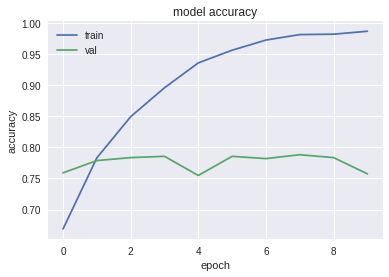

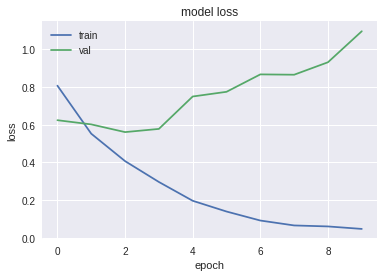

In [23]:
# summarize history for accuracy
plt.plot(history['train_acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Custom Embedding Layer using Bidirectional LSTM

In [0]:
num_classes = 3
class BiLSTM_Model(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_size):
      
      super(BiLSTM_Model, self).__init__()
      self.num_layers = 1
      self.batch_size = batch_size
      self.hidden_dim = hidden_dim
      
      self.word_embeddings = nn.Embedding(vocab_size, embedding_dim) 
      # The LSTM takes word embeddings as inputs, and outputs hidden states
      # with dimensionality hidden_dim.
      self.bilstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=self.num_layers, bidirectional=True) 
      self.fc = nn.Linear(hidden_dim*2, num_classes)
      self.hidden = self.init_hidden()      
      
    def forward(self, sentence):
      
        embeds = self.word_embeddings(sentence)
        # [sent_len, batch_size] --> [sent_len, batch_size, emb_dim]
        bilstm_out, self.hidden = self.bilstm(embeds, self.hidden) 
        # [sent_len, batch_size, emb_dim] --> [seq_len, batch, num_directions*hidden_size]
        preds = self.fc(bilstm_out[-1])
        # [batch, num_directions*hidden_size] --> [batch_size, 1]
        return preds
      
      
    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # The axes semantics are (num_layers*2, minibatch_size, hidden_dim)
        return (torch.zeros(self.num_layers*2, self.batch_size, self.hidden_dim).to(device),
                torch.zeros(self.num_layers*2, self.batch_size, self.hidden_dim).to(device))
        

In [25]:
model = BiLSTM_Model(vocab_size=len(TEXT.vocab), embedding_dim=300, hidden_dim=128, batch_size=BATCH_SIZE)
model.to(device)

BiLSTM_Model(
  (word_embeddings): Embedding(15002, 300)
  (bilstm): LSTM(300, 128, bidirectional=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

In [0]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
criterion = nn.CrossEntropyLoss()

In [0]:
# Create training and validation dataloaders
dataloaders_dict = {'train': train_iterator, 
                    'val': val_iterator}

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, batch_size=BATCH_SIZE):
    since = time.time()

    history = dict()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    skip_count = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            

            # Iterate over data.
            for data in dataloaders[phase]:
                inputs, labels = data.text, data.airline_sentiment
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # we need to clear out the hidden state of the LSTM,
                        # detaching it from its history on the last instance.
                        model.batch_size = inputs.shape[1]
                        model.hidden = model.init_hidden()
                        
                        outputs = model(inputs).squeeze(1)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                        
                    else:
                        model.batch_size = inputs.shape[1]
                        model.hidden = model.init_hidden()
                        
                        outputs = model(inputs).squeeze(1)
                        loss = criterion(outputs, labels)


                # statistics
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                corrects = (predicted == labels).float()
                acc = corrects.sum()/len(corrects)
                running_corrects += acc.item()

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects / len(dataloaders[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase+'_acc' in history:
                # append the new number to the existing array at this slot
                history[phase+'_acc'].append(epoch_acc)
            else:
                # create a new array in this slot
                history[phase+'_acc'] = [epoch_acc]
            
            if phase+'_loss' in history:
                # append the new number to the existing array at this slot
                history[phase+'_loss'].append(epoch_loss)
            else:
                # create a new array in this slot
                history[phase+'_loss'] = [epoch_loss]            

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [29]:
model, history = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.8115 Acc: 0.6642
val Loss: 0.6023 Acc: 0.7560
Epoch 1/9
----------
train Loss: 0.5474 Acc: 0.7838
val Loss: 0.5629 Acc: 0.7731
Epoch 2/9
----------
train Loss: 0.3957 Acc: 0.8528
val Loss: 0.5931 Acc: 0.7825
Epoch 3/9
----------
train Loss: 0.2803 Acc: 0.9036
val Loss: 0.6323 Acc: 0.7721
Epoch 4/9
----------
train Loss: 0.1922 Acc: 0.9389
val Loss: 0.6952 Acc: 0.7669
Epoch 5/9
----------
train Loss: 0.1352 Acc: 0.9584
val Loss: 0.7886 Acc: 0.7580
Epoch 6/9
----------
train Loss: 0.0938 Acc: 0.9732
val Loss: 0.9022 Acc: 0.7685
Epoch 7/9
----------
train Loss: 0.0642 Acc: 0.9826
val Loss: 1.0732 Acc: 0.7460
Epoch 8/9
----------
train Loss: 0.0562 Acc: 0.9849
val Loss: 0.9724 Acc: 0.7913
Epoch 9/9
----------
train Loss: 0.0474 Acc: 0.9866
val Loss: 1.0127 Acc: 0.7835
Training complete in 0m 35s
Best val Acc: 0.791327


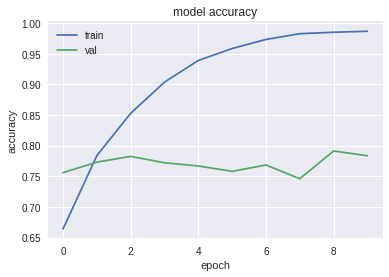

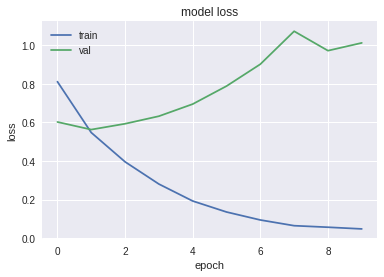

In [30]:
# summarize history for accuracy
plt.plot(history['train_acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Custom Embedding Layer using GRU

In [0]:
num_classes = 3
class GRU_Model(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, batch_size):
      
      super(GRU_Model, self).__init__()
      self.num_layers = 1
      self.batch_size = batch_size
      self.hidden_dim = hidden_dim
      
      self.word_embeddings = nn.Embedding(vocab_size, embedding_dim) 
      # The LSTM takes word embeddings as inputs, and outputs hidden states
      # with dimensionality hidden_dim.
      self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=self.num_layers)
      self.fc = nn.Linear(hidden_dim, num_classes)
      self.hidden = self.init_hidden()      
      
    def forward(self, sentence):
      
        embeds = self.word_embeddings(sentence)
        # [sent_len, batch_size] --> [sent_len, batch_size, emb_dim]
        gru_out, self.hidden = self.gru(embeds, self.hidden) 
        # [sent_len, batch_size, emb_dim] --> [seq_len, batch, num_directions*hidden_size]
        preds = self.fc(gru_out[-1].squeeze(0))
        # [batch, num_directions*hidden_size] --> [batch_size, 1]
        return preds
      
      
    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(device)
        

In [32]:
model = GRU_Model(vocab_size=len(TEXT.vocab), embedding_dim=300, hidden_dim=128, batch_size=BATCH_SIZE)
model.to(device)

GRU_Model(
  (word_embeddings): Embedding(15002, 300)
  (gru): GRU(300, 128)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

In [0]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
criterion = nn.CrossEntropyLoss()

In [0]:
# Create training and validation dataloaders
dataloaders_dict = {'train': train_iterator, 
                    'val': val_iterator}

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, batch_size=BATCH_SIZE):
    since = time.time()

    history = dict()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    skip_count = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            

            # Iterate over data.
            for data in dataloaders[phase]:
                inputs, labels = data.text, data.airline_sentiment
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # we need to clear out the hidden state of the LSTM,
                        # detaching it from its history on the last instance.
                        model.batch_size = inputs.shape[1]
                        model.hidden = model.init_hidden()
                        
                        outputs = model(inputs).squeeze(1)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                        
                    else:
                        model.batch_size = inputs.shape[1]
                        model.hidden = model.init_hidden()
                        
                        outputs = model(inputs).squeeze(1)
                        loss = criterion(outputs, labels)


                # statistics
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                corrects = (predicted == labels).float()
                acc = corrects.sum()/len(corrects)
                running_corrects += acc.item()

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects / len(dataloaders[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase+'_acc' in history:
                # append the new number to the existing array at this slot
                history[phase+'_acc'].append(epoch_acc)
            else:
                # create a new array in this slot
                history[phase+'_acc'] = [epoch_acc]
            
            if phase+'_loss' in history:
                # append the new number to the existing array at this slot
                history[phase+'_loss'].append(epoch_loss)
            else:
                # create a new array in this slot
                history[phase+'_loss'] = [epoch_loss]            

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


In [36]:
model, history = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.7556 Acc: 0.6813
val Loss: 0.6327 Acc: 0.7460
Epoch 1/9
----------
train Loss: 0.4965 Acc: 0.8057
val Loss: 0.5461 Acc: 0.7737
Epoch 2/9
----------
train Loss: 0.3435 Acc: 0.8724
val Loss: 0.5674 Acc: 0.7835
Epoch 3/9
----------
train Loss: 0.2328 Acc: 0.9154
val Loss: 0.6658 Acc: 0.7939
Epoch 4/9
----------
train Loss: 0.1415 Acc: 0.9535
val Loss: 0.7722 Acc: 0.7835
Epoch 5/9
----------
train Loss: 0.0893 Acc: 0.9724
val Loss: 0.8849 Acc: 0.7669
Epoch 6/9
----------
train Loss: 0.0618 Acc: 0.9805
val Loss: 0.9976 Acc: 0.7549
Epoch 7/9
----------
train Loss: 0.0434 Acc: 0.9875
val Loss: 1.0308 Acc: 0.7653
Epoch 8/9
----------
train Loss: 0.0351 Acc: 0.9894
val Loss: 1.1115 Acc: 0.7617
Epoch 9/9
----------
train Loss: 0.0314 Acc: 0.9905
val Loss: 1.1286 Acc: 0.7757
Training complete in 0m 27s
Best val Acc: 0.793931


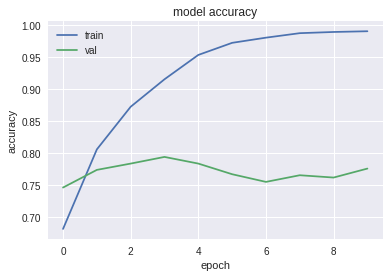

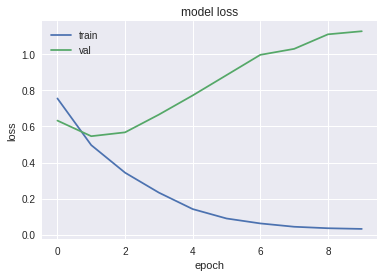

In [37]:
# summarize history for accuracy
plt.plot(history['train_acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## BERT

In [38]:
! git clone https://github.com/huggingface/pytorch-pretrained-BERT.git

Cloning into 'pytorch-pretrained-BERT'...
remote: Enumerating objects: 2550, done.
remote: Total 2550 (delta 0), reused 0 (delta 0), pack-reused 2550
Receiving objects: 100% (2550/2550), 1.22 MiB | 9.15 MiB/s, done.
Resolving deltas: 100% (1724/1724), done.


In [39]:
! wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
! unzip uncased_L-12_H-768_A-12.zip

! wget https://storage.googleapis.com/bert_models/2018_10_18/cased_L-12_H-768_A-12.zip
! unzip cased_L-12_H-768_A-12.zip

--2019-03-27 20:40:06--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.70.128, 2607:f8b0:4001:c1e::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.70.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  98.2MB/s    in 4.0s    

2019-03-27 20:40:10 (98.2 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  
--2019-03-27 20:

In [40]:
%cd /content/

/content


In [0]:
import pandas as pd
import pytorch_pretrained_bert
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from pandas import DataFrame
 
le = LabelEncoder()
 
df = pd.read_csv('https://query.data.world/s/hus7zihvuo5vt65cnv4fcfn2ppfj6y', encoding = "ISO-8859-1")

# Creating train and dev dataframes according to BERT
df_bert = pd.DataFrame({'user_id': df['_unit_id'],
            'label': le.fit_transform(df['airline_sentiment']),
            'alpha': ['a'] * df.shape[0],
            'text': df['text'].replace(r'\n',' ',regex=True)})

df_bert_train, df_bert_dev = train_test_split(df_bert, test_size=0.01)
  
cols = ['user_id', 'label', 'alpha', 'text']
     
# # Creating test dataframe according to BERT
# df_test = pd.read_csv("data/test.csv")
# df_bert_test = pd.DataFrame({'User_ID': df_test['_unit_id'],
#                  'text': df_test['text']})
 
# Saving dataframes to .tsv format as required by BERT
df_bert_train[cols].to_csv('data/train.tsv', sep='\t', index=False, header=False)
df_bert_dev[cols].to_csv('data/dev.tsv', sep='\t', index=False, header=False)
df_bert_dev[cols].to_csv('data/test.tsv', sep='\t', index=False, header=True)

In [43]:
%cd /content/pytorch-pretrained-BERT/examples/

/content/pytorch-pretrained-BERT/examples


In [48]:
%%writefile bert_classifier.py
# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""BERT finetuning runner."""

from __future__ import absolute_import, division, print_function

import argparse
import csv
import logging
import os
import random
import sys

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

from pytorch_pretrained_bert.file_utils import PYTORCH_PRETRAINED_BERT_CACHE
from pytorch_pretrained_bert.modeling import BertForSequenceClassification, BertConfig, WEIGHTS_NAME, CONFIG_NAME
from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.optimization import BertAdam, warmup_linear

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)


class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                if sys.version_info[0] == 2:
                    line = list(unicode(cell, 'utf-8') for cell in line)
                lines.append(line)
            return lines


class MrpcProcessor(DataProcessor):
    """Processor for the MRPC data set (GLUE version)."""

    def get_train_examples(self, data_dir):
        """See base class."""
        logger.info("LOOKING AT {}".format(os.path.join(data_dir, "train.tsv")))
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_labels(self):
        """See base class."""
        return ["0", "1"]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, i)
            text_a = line[3]
            text_b = line[4]
            label = line[0]
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
        return examples


class MnliProcessor(DataProcessor):
    """Processor for the MultiNLI data set (GLUE version)."""

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev_matched.tsv")),
            "dev_matched")

    def get_labels(self):
        """See base class."""
        return ["contradiction", "entailment", "neutral"]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, line[0])
            text_a = line[8]
            text_b = line[9]
            label = line[-1]
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
        return examples


class ColaProcessor(DataProcessor):
    """Processor for the CoLA data set (GLUE version)."""

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_labels(self):
        """See base class."""
        return ["0", "1", "2"]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            guid = "%s-%s" % (set_type, i)
            text_a = line[3]
            label = line[1]
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples


class Sst2Processor(DataProcessor):
    """Processor for the SST-2 data set (GLUE version)."""

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_labels(self):
        """See base class."""
        return ["0", "1"]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, i)
            text_a = line[0]
            label = line[1]
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples


def convert_examples_to_features(examples, label_list, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""

    label_map = {label : i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label_map[example.label]
        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            logger.info("label: %s (id = %d)" % (example.label, label_id))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
    return features


def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs == labels)

def main():
    parser = argparse.ArgumentParser()

    ## Required parameters
    parser.add_argument("--data_dir",
                        default=None,
                        type=str,
                        required=True,
                        help="The input data dir. Should contain the .tsv files (or other data files) for the task.")
    parser.add_argument("--bert_model", default=None, type=str, required=True,
                        help="Bert pre-trained model selected in the list: bert-base-uncased, "
                        "bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, "
                        "bert-base-multilingual-cased, bert-base-chinese.")
    parser.add_argument("--task_name",
                        default=None,
                        type=str,
                        required=True,
                        help="The name of the task to train.")
    parser.add_argument("--output_dir",
                        default=None,
                        type=str,
                        required=True,
                        help="The output directory where the model predictions and checkpoints will be written.")

    ## Other parameters
    parser.add_argument("--cache_dir",
                        default="",
                        type=str,
                        help="Where do you want to store the pre-trained models downloaded from s3")
    parser.add_argument("--max_seq_length",
                        default=128,
                        type=int,
                        help="The maximum total input sequence length after WordPiece tokenization. \n"
                             "Sequences longer than this will be truncated, and sequences shorter \n"
                             "than this will be padded.")
    parser.add_argument("--do_train",
                        action='store_true',
                        help="Whether to run training.")
    parser.add_argument("--do_eval",
                        action='store_true',
                        help="Whether to run eval on the dev set.")
    parser.add_argument("--do_lower_case",
                        action='store_true',
                        help="Set this flag if you are using an uncased model.")
    parser.add_argument("--train_batch_size",
                        default=32,
                        type=int,
                        help="Total batch size for training.")
    parser.add_argument("--eval_batch_size",
                        default=8,
                        type=int,
                        help="Total batch size for eval.")
    parser.add_argument("--learning_rate",
                        default=5e-5,
                        type=float,
                        help="The initial learning rate for Adam.")
    parser.add_argument("--num_train_epochs",
                        default=3.0,
                        type=float,
                        help="Total number of training epochs to perform.")
    parser.add_argument("--warmup_proportion",
                        default=0.1,
                        type=float,
                        help="Proportion of training to perform linear learning rate warmup for. "
                             "E.g., 0.1 = 10%% of training.")
    parser.add_argument("--no_cuda",
                        action='store_true',
                        help="Whether not to use CUDA when available")
    parser.add_argument("--local_rank",
                        type=int,
                        default=-1,
                        help="local_rank for distributed training on gpus")
    parser.add_argument('--seed',
                        type=int,
                        default=42,
                        help="random seed for initialization")
    parser.add_argument('--gradient_accumulation_steps',
                        type=int,
                        default=1,
                        help="Number of updates steps to accumulate before performing a backward/update pass.")
    parser.add_argument('--fp16',
                        action='store_true',
                        help="Whether to use 16-bit float precision instead of 32-bit")
    parser.add_argument('--loss_scale',
                        type=float, default=0,
                        help="Loss scaling to improve fp16 numeric stability. Only used when fp16 set to True.\n"
                             "0 (default value): dynamic loss scaling.\n"
                             "Positive power of 2: static loss scaling value.\n")
    parser.add_argument('--server_ip', type=str, default='', help="Can be used for distant debugging.")
    parser.add_argument('--server_port', type=str, default='', help="Can be used for distant debugging.")
    args = parser.parse_args()

    if args.server_ip and args.server_port:
        # Distant debugging - see https://code.visualstudio.com/docs/python/debugging#_attach-to-a-local-script
        import ptvsd
        print("Waiting for debugger attach")
        ptvsd.enable_attach(address=(args.server_ip, args.server_port), redirect_output=True)
        ptvsd.wait_for_attach()

    processors = {
        "cola": ColaProcessor,
        "mnli": MnliProcessor,
        "mrpc": MrpcProcessor,
        "sst-2": Sst2Processor,
    }

    num_labels_task = {
        "cola": 3,
        "sst-2": 2,
        "mnli": 3,
        "mrpc": 2,
    }

    if args.local_rank == -1 or args.no_cuda:
        device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")
        n_gpu = torch.cuda.device_count()
    else:
        torch.cuda.set_device(args.local_rank)
        device = torch.device("cuda", args.local_rank)
        n_gpu = 1
        # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
        torch.distributed.init_process_group(backend='nccl')
    logger.info("device: {} n_gpu: {}, distributed training: {}, 16-bits training: {}".format(
        device, n_gpu, bool(args.local_rank != -1), args.fp16))

    if args.gradient_accumulation_steps < 1:
        raise ValueError("Invalid gradient_accumulation_steps parameter: {}, should be >= 1".format(
                            args.gradient_accumulation_steps))

    args.train_batch_size = args.train_batch_size // args.gradient_accumulation_steps

    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

    if not args.do_train and not args.do_eval:
        raise ValueError("At least one of `do_train` or `do_eval` must be True.")

    if os.path.exists(args.output_dir) and os.listdir(args.output_dir) and args.do_train:
        raise ValueError("Output directory ({}) already exists and is not empty.".format(args.output_dir))
    if not os.path.exists(args.output_dir):
        os.makedirs(args.output_dir)

    task_name = args.task_name.lower()

    if task_name not in processors:
        raise ValueError("Task not found: %s" % (task_name))

    processor = processors[task_name]()
    num_labels = num_labels_task[task_name]
    label_list = processor.get_labels()

    tokenizer = BertTokenizer.from_pretrained(args.bert_model, do_lower_case=args.do_lower_case)

    train_examples = None
    num_train_optimization_steps = None
    if args.do_train:
        train_examples = processor.get_train_examples(args.data_dir)
        num_train_optimization_steps = int(
            len(train_examples) / args.train_batch_size / args.gradient_accumulation_steps) * args.num_train_epochs
        if args.local_rank != -1:
            num_train_optimization_steps = num_train_optimization_steps // torch.distributed.get_world_size()

    # Prepare model
    cache_dir = args.cache_dir if args.cache_dir else os.path.join(str(PYTORCH_PRETRAINED_BERT_CACHE), 'distributed_{}'.format(args.local_rank))
    model = BertForSequenceClassification.from_pretrained(args.bert_model,
              cache_dir=cache_dir,
              num_labels = num_labels)
    if args.fp16:
        model.half()
    model.to(device)
    if args.local_rank != -1:
        try:
            from apex.parallel import DistributedDataParallel as DDP
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use distributed and fp16 training.")

        model = DDP(model)
    elif n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Prepare optimizer
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
    if args.fp16:
        try:
            from apex.optimizers import FP16_Optimizer
            from apex.optimizers import FusedAdam
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use distributed and fp16 training.")

        optimizer = FusedAdam(optimizer_grouped_parameters,
                              lr=args.learning_rate,
                              bias_correction=False,
                              max_grad_norm=1.0)
        if args.loss_scale == 0:
            optimizer = FP16_Optimizer(optimizer, dynamic_loss_scale=True)
        else:
            optimizer = FP16_Optimizer(optimizer, static_loss_scale=args.loss_scale)

    else:
        optimizer = BertAdam(optimizer_grouped_parameters,
                             lr=args.learning_rate,
                             warmup=args.warmup_proportion,
                             t_total=num_train_optimization_steps)

    global_step = 0
    nb_tr_steps = 0
    tr_loss = 0
    if args.do_train:
        train_features = convert_examples_to_features(
            train_examples, label_list, args.max_seq_length, tokenizer)
        logger.info("***** Running training *****")
        logger.info("  Num examples = %d", len(train_examples))
        logger.info("  Batch size = %d", args.train_batch_size)
        logger.info("  Num steps = %d", num_train_optimization_steps)
        all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
        all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
        all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)
        all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.long)
        train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
        if args.local_rank == -1:
            train_sampler = RandomSampler(train_data)
        else:
            train_sampler = DistributedSampler(train_data)
        train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=args.train_batch_size)

        model.train()
        for _ in trange(int(args.num_train_epochs), desc="Epoch"):
            tr_loss = 0
            nb_tr_examples, nb_tr_steps = 0, 0
            for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
                batch = tuple(t.to(device) for t in batch)
                input_ids, input_mask, segment_ids, label_ids = batch
                loss = model(input_ids, segment_ids, input_mask, label_ids)
                if n_gpu > 1:
                    loss = loss.mean() # mean() to average on multi-gpu.
                if args.gradient_accumulation_steps > 1:
                    loss = loss / args.gradient_accumulation_steps

                if args.fp16:
                    optimizer.backward(loss)
                else:
                    loss.backward()

                tr_loss += loss.item()
                nb_tr_examples += input_ids.size(0)
                nb_tr_steps += 1
                if (step + 1) % args.gradient_accumulation_steps == 0:
                    if args.fp16:
                        # modify learning rate with special warm up BERT uses
                        # if args.fp16 is False, BertAdam is used that handles this automatically
                        lr_this_step = args.learning_rate * warmup_linear(global_step/num_train_optimization_steps, args.warmup_proportion)
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = lr_this_step
                    optimizer.step()
                    optimizer.zero_grad()
                    global_step += 1

        # Save a trained model and the associated configuration
        model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
        output_model_file = os.path.join(args.output_dir, WEIGHTS_NAME)
        torch.save(model_to_save.state_dict(), output_model_file)
        output_config_file = os.path.join(args.output_dir, CONFIG_NAME)
        with open(output_config_file, 'w') as f:
            f.write(model_to_save.config.to_json_string())

        # Load a trained model and config that you have fine-tuned
        config = BertConfig(output_config_file)
        model = BertForSequenceClassification(config, num_labels=num_labels)
        model.load_state_dict(torch.load(output_model_file))
    else:
        model = BertForSequenceClassification.from_pretrained(args.bert_model, num_labels=num_labels)
    model.to(device)

    if args.do_eval and (args.local_rank == -1 or torch.distributed.get_rank() == 0):
        eval_examples = processor.get_dev_examples(args.data_dir)
        eval_features = convert_examples_to_features(
            eval_examples, label_list, args.max_seq_length, tokenizer)
        logger.info("***** Running evaluation *****")
        logger.info("  Num examples = %d", len(eval_examples))
        logger.info("  Batch size = %d", args.eval_batch_size)
        all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
        all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
        all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
        all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.long)
        eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
        # Run prediction for full data
        eval_sampler = SequentialSampler(eval_data)
        eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=args.eval_batch_size)

        model.eval()
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0

        for input_ids, input_mask, segment_ids, label_ids in tqdm(eval_dataloader, desc="Evaluating"):
            input_ids = input_ids.to(device)
            input_mask = input_mask.to(device)
            segment_ids = segment_ids.to(device)
            label_ids = label_ids.to(device)

            with torch.no_grad():
                tmp_eval_loss = model(input_ids, segment_ids, input_mask, label_ids)
                logits = model(input_ids, segment_ids, input_mask)

            logits = logits.detach().cpu().numpy()
            label_ids = label_ids.to('cpu').numpy()
            tmp_eval_accuracy = accuracy(logits, label_ids)

            eval_loss += tmp_eval_loss.mean().item()
            eval_accuracy += tmp_eval_accuracy

            nb_eval_examples += input_ids.size(0)
            nb_eval_steps += 1

        eval_loss = eval_loss / nb_eval_steps
        eval_accuracy = eval_accuracy / nb_eval_examples
        loss = tr_loss/nb_tr_steps if args.do_train else None
        result = {'eval_loss': eval_loss,
                  'eval_accuracy': eval_accuracy,
                  'global_step': global_step,
                  'loss': loss}

        output_eval_file = os.path.join(args.output_dir, "eval_results.txt")
        with open(output_eval_file, "w") as writer:
            logger.info("***** Eval results *****")
            for key in sorted(result.keys()):
                logger.info("  %s = %s", key, str(result[key]))
                writer.write("%s = %s\n" % (key, str(result[key])))

if __name__ == "__main__":
    main()


Writing bert_classifier.py


In [49]:
!python bert_classifier.py \
  --task_name cola \
  --do_train \
  --do_eval \
  --do_lower_case \
  --data_dir /content/data \
  --bert_model bert-base-uncased \
  --max_seq_length 100 \
  --train_batch_size 32 \
  --learning_rate 2e-5 \
  --num_train_epochs 3.0 \
  --output_dir /content/output/

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.
03/27/2019 20:51:08 - INFO - __main__ -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: False
03/27/2019 20:51:09 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
03/27/2019 20:51:09 - INFO - pytorch_pretrained_bert.modeling -   loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /root/.pytorch_pretrained_bert/distributed_-1/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
03/27/2019 20:51:09 - INFO - pytorch_pretrained_bert.modeling -   extracting archive file

## GPT-2 

In [62]:
!python run_gpt2.py

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.
Namespace(batch_size=-1, length=-1, model_name_or_path='gpt2', nsamples=1, seed=0, temperature=1, top_k=0, unconditional=False)
03/27/2019 21:37:05 - INFO - pytorch_pretrained_bert.tokenization_gpt2 -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-vocab.json from cache at /root/.pytorch_pretrained_bert/f2808208f9bec2320371a9f5f891c184ae0b674ef866b79c58177067d15732dd.1512018be4ba4e8726e41b9145129dc30651ea4fec86aa61f4b9f40bf94eac71
03/27/2019 21:37:05 - INFO - pytorch_pretrained_bert.tokenization_gpt2 -   loading merges file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-merges.txt from cache at /root/.pytorch_pretrained_bert/d629f792e430b3c76a1291bb2766b0a047e36fae0588f9dbc1ae51decdff691b.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda
03/27/2019 21:37:05 - INFO - pytorch_pretrained_bert.modeling_gpt2 -   loading weights file https://s3